# 示例：特征选择 - 预测泰坦尼克号乘客的生存情况

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx

import dynex
import dimod

这份笔记演示了一个$\left(\frac{n}{k}\right)$优化问题的制定，该问题将在Dynex神经形态平台上计算。本笔记中示例问题的方法，即机器学习中的特征选择，适用于各种领域的问题，例如金融投资组合优化。本笔记应该能够帮助您理解在Dynex计算平台上解决优化问题时使用的技术和Dimod工具。

## 什么是特征选择？

统计和机器学习模型使用一组输入变量（"特征"）来预测感兴趣的输出变量。特征选择可以作为模型设计过程的一部分：从潜在的众多特征中选择一个高度信息丰富的子集可以简化模型并降低维度。

例如，为了构建一个模型来预测温室西红柿的成熟，农夫麦克唐纳每天记录日期、中午温度、日照时间、云层程度、定量供水和肥料、土壤湿度、电照明时间等信息。这些测量数据构成了潜在特征的列表。经过一两个生长周期的分析后，她发现这些特征与作物产量之间存在一些相关性：

- 肥料似乎是果实大小的强有力预测因子。
- 多云和日照时间似乎对生长的预测效果不好。
- 水供应和土壤湿度似乎是高度相关的一对强有力的腐烂风险的预测因子。
- 农夫麦克唐纳怀疑她的温室使用电灯减少了对季节和阳光的依赖。她可以通过舍弃日期、日照时间和多云来简化她的模型。她可以只记录水供应或只记录土壤湿度，而不是两者都记录。

对于具有大量潜在输入信息的系统，例如天气预测或图像识别，模型的复杂性和所需的计算资源可能令人望而却步。特征选择有助于使这些模型更加可行。

然而，最佳的特征选择本身可能是一个复杂的问题。这个示例介绍了一种基于复杂概率计算的特征选择优化方法。这个计算被提交到量子计算机以求解。

## 互信息进行特征选择

有各种各样的特征选择方法。例如，如果您正在构建一个机器学习模型，有六个潜在的特征，您可能会首先考虑先使用每个特征进行训练，然后使用两个特征的子集的所有15种组合，然后使用三个特征的子集的所有20种组合，以此类推。然而，统计方法更加高效。

可以指导此选择的一种统计标准是互信息（MI）。接下来的部分将根据泰坦尼克号数据集解释信息和互信息。

变量X和Y之间的互信息定义如下：

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>I</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>;</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <munder>
    <mo data-mjx-texclass="OP">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>y</mi>
      <mo>&#x2208;</mo>
      <mi>Y</mi>
    </mrow>
  </munder>
  <munder>
    <mo data-mjx-texclass="OP">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>x</mi>
      <mo>&#x2208;</mo>
      <mi>X</mi>
    </mrow>
  </munder>
  <mi>p</mi>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo>,</mo>
  <mi>y</mi>
  <mo stretchy="false">)</mo>
  <mi>log</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mfrac>
    <mrow>
      <mi>p</mi>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo>,</mo>
      <mi>y</mi>
      <mo stretchy="false">)</mo>
    </mrow>
    <mrow>
      <mi>p</mi>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo stretchy="false">)</mo>
      <mi>p</mi>
      <mo stretchy="false">(</mo>
      <mi>y</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </mfrac>
</math>

where p(x) and p(y)are marginal probabilities of X and Y, and p(y,y) the joint probability. Equivalently,

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>I</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>;</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <mi>Y</mi>
  <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
  <mi>X</mi>
  <mo stretchy="false">)</mo>
</math>

其中p(x)和p(y)是X和Y的边际概率，p(y,y)是联合概率。

互信息（MI）量化了通过观察另一个随机变量而获得关于一个随机变量的信息量。直观地说，当它们之间的互信息很高时，基于一对特征中的一个特征（例如，农夫麦克唐纳的供水量和土壤湿度）的模型将更好地重现它们的联合贡献

## 辅助函数（MI 和绘图）

以下单元格实现了互信息计算以及一些用于绘制数据的函数：

In [2]:
# Define MI calculations
def prob(dataset):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [len(np.unique(dataset[:, ci])) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)


def shannon_entropy(p):
    """Shannon entropy H(X) is the negative sum of P(X)log(P(X)) for probability
    distribution P(X).
    """
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)


def conditional_shannon_entropy(p, *conditional_indices):
    """Conditional Shannon entropy H(X|Y) = H(X,Y) - H(Y)."""

    # Sanity check on validity of conditional_indices.  In particular,
    # try to trap issues in which dimensions have been removed from
    # probability table through marginalization, but
    # conditional_indices were not updated accordingly.
    assert(all(ci < p.ndim for ci in conditional_indices))

    axis = tuple(i for i in np.arange(len(p.shape))
                 if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

def mutual_information(prob, j):
    """Mutual information between variables X and variable Y.

    Calculated as I(X; Y) = H(X) - H(X|Y)."""

    return (shannon_entropy(np.sum(prob, axis=j))
            - conditional_shannon_entropy(prob, j))

In [3]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.

    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    # Compute an updated version of the conditional indices for use
    # when the probability table is marginalized over dimension j.
    # This marginalization removes one dimension, so any conditional
    # indices pointing to dimensions after this one must be adjusted
    # accordingly.
    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))


def maximum_energy_delta(bqm):
    """Compute conservative bound on maximum change in energy when flipping a single variable"""
    return max(abs(bqm.get_linear(i))
               + sum(abs(bqm.get_quadratic(i,j))
                     for j, _ in bqm.iter_neighborhood(i))
               for i in bqm.variables)


def mutual_information_bqm(dataset, features, target):
    """Build a BQM that maximizes MI between survival and a subset of features"""
    variables = ((feature, -mutual_information(prob(dataset[[target, feature]].values), 1))
                 for feature in features)
    interactions = ((f0, f1, -conditional_mutual_information(prob(dataset[[target, f0, f1]].values), 1, 2))
                    for f0, f1 in itertools.permutations(features, 2))
    return dimod.BinaryQuadraticModel(variables, interactions, 0, dimod.BINARY)


def add_combination_penalty(bqm, k, penalty):
    """Create a new BQM with an additional penalty biased towards k-combinations"""
    kbqm = dimod.generators.combinations(bqm.variables, k, strength=penalty)
    kbqm.update(bqm)
    return kbqm

In [4]:
from matplotlib.gridspec import GridSpec


def sub_plot(size, small, big, x, subtitles, y, *y2):
    gs = GridSpec(big + 1, small)
    plt.figure(figsize=size)
    for i in range(small):
        ax = 'ax_' + str(i)
        ax = plt.subplot(gs[0, i])
        ax.set_title(subtitles[i])
        if y2:
            ax.plot(x, y2[0]['out'].values, 'ro')
            ax.plot(x, y[y.columns[i]].values, 'bv')
            ax.legend(["out", "model"])
        else:
            ax.plot(x, y[y.columns[i]].values)

    if big:
        axy = plt.subplot(gs[1, :])
        i += 1
        axy.set_title(y.columns[i])
        axy.plot(x, y[y.columns[i]].values, 'r')
    return plt

def plot_toy_signals(df):
    sub_plot((10, 8), 3, True, np.linspace(-np.pi, np.pi, len(df)), df.columns, df)
    plt.suptitle("Toy Problem: System Inputs and Output", fontsize=15)

def plot_two_var_model(df1, df2):
    subtitles = ["Modeling %s and %s" % f0f1 for f0f1 in df1.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df1)), subtitles, df1, df2)
    plt.suptitle("Toy Problem: Output Vesus Two-Signal Model", fontsize=15)

def plot_lingress(df, toy):
    subtitles = ["%s correlation coefficient: %.2f" % var_rval for var_rval in df.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df)), subtitles, df, toy)
    plt.suptitle("Toy Problem: Linear Regression", fontsize=15)

def plot_se(data):
    df = pd.DataFrame(data)
    plt.figure(figsize=(5, 4))
    plt.plot(df[['Bins']].values, df[['Maximum']].values, 'ro',
             df[['Bins']].values, df[['Uniform']].values, 'b',
             df[['Bins']].values, df[['Exp']].values, 'g',
             df[['Bins']].values, df[['Vals']].values, 'y')
    plt.title("Shannon Entropy")
    plt.xlabel("Bins")
    plt.ylabel("Entropy")
    plt.legend(['Maximum', 'Uniform', 'Exp', 'Vals'])

def plot_mi(scores):
    if len(scores) > 5:
        plt.figure(figsize=(8, 5))
    else:
        plt.figure(figsize=(4, 4))
    labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title("Mutual Information")
    plt.ylabel("MI with Variable of Interest")
    plt.show

def plot_solutions(result):
    features = []
    energies = []
    for sample, energy in result.data(['sample', 'energy']):
        energies.append(energy)
        features.append([key for (key, value) in sample.items() if value == 1])
    plt.figure(figsize=(4, 4))
    plt.bar(np.arange(len(features)), energies)
    plt.xticks(np.arange(len(features)), features, rotation=90)
    plt.title("Toy Problem: Unconstrained Solution")
    plt.ylabel("Energy")

def plot_features(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

In [5]:
def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_title(f"BQM with {len(bqm)} nodes and {len(bqm.quadratic)} edges")
    nx.draw_circular(g, with_labels=True, node_size=3000, node_color="y")
    plt.show()

def plot_feature_selection(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

## 特征选择：预测泰坦尼克号乘客的生存

此示例演示了MIQUBO方法，通过查找用于预测泰坦尼克号乘客生存的最佳特征集。它使用文件formatted_titanic.csv中提供的记录，这是船员记录的乘客信息的经过特征工程处理的版本，记录了每位乘客的生存情况以及性别、头衔、舱位、上船港口等信息。

下一个单元格将文件读入pandas DataFrame。

In [6]:
titanic = pd.read_csv("formatted_titanic.csv")

绘制每个特征与兴趣变量（生存）之间的互信息排名：

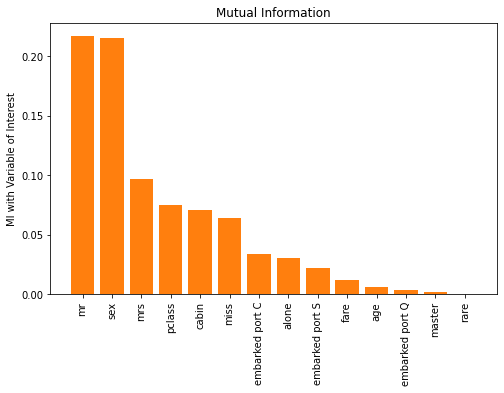

In [7]:
mi = {}
features = list(set(titanic.columns).difference(('survived',)))

for feature in features:
    mi[feature] = mutual_information(prob(titanic[['survived', feature]].values), 1)

plot_mi(mi)

接下来的单元格绘制了所有特征和三个变量排列的互信息和条件互信息的值。请注意值在紧凑的值范围内聚集：

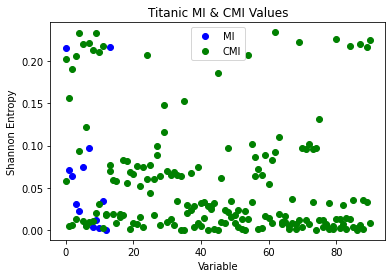

In [8]:
plt.plot(range(len(features)), [mutual_information(prob(titanic[['survived', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("Titanic MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])

请注意，有许多有效的解决方案形成了一个小的集群（图中所示图中前五个最佳解决方案之间的能量差异在小数点后的第四位）。神经形态计算的优势在于快速找到复杂问题的多个良好解决方案，而不是作为双精度数值计算器。在此数据集上朴素运行，它可以找到许多良好的解决方案，但不太可能找到确切的最优解决方案。

## 构建基于MI的二进制二次模型 (BQM)

选择前8个在上面找到的MI排名中的特征：

In [9]:
keep = 8

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
titanic = titanic[[column[0] for column in sorted_mi[0:keep]] + ["survived"]]
features = list(set(titanic.columns).difference(('survived',)))

print("Submitting for {} features: {}".format(keep, features))

Submitting for 8 features: ['sex', 'cabin', 'miss', 'alone', 'pclass', 'mrs', 'embarked port C', 'mr']


基于问题的MI和CMI计算一个BQM :

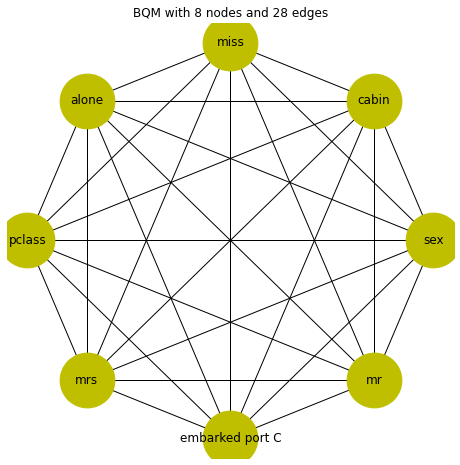

In [10]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# 添加特征
for feature in features:
    mi = mutual_information(prob(titanic[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()  

plot_bqm(bqm)

##  将 Dynex 设置为采样器：

按照 Dynex SDK 文档中描述的标准方式配置 Dynex Annealer 作为您的采样器。

##  将问题提交以获取所有 k 值的结果。

对于所有选择的特征数量 k，设置一个 $\left(\frac{n}{k}\right)$ 惩罚，提交一个更新后的 BQM 以进行求解。在本例中，我们将使用 256 个读数，这意味着我们将在 256 个不同的 Dynex 芯片上运行采样问题，并使用不同的初始条件进行 1000 个积分时间步的模拟。

In [12]:
selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    # Dynex Sampler:
    model = dynex.BQM(kbqm);
    sampler = dynex.DynexSampler(model);
    
    # Map the result to the variables:
    sampleset = sampler.sample(num_reads=256, annealing_time = 1000);
    sample = {};
    i = 0;
    for var in sampler.var_mappings:
        if float(sampleset[-1]['sample'][i]) < 0:
            sample[var] = 0;
        else:
            sample[var] = 1;
        i = i + 1
    
    for fi, f in enumerate(features):
        selected_features[k-1, fi] = sample[f] # best[f]


time: 0.04s #workers: 1 #chips: 256 #steps: 1000 global falsified softs: 6 global energy: 26768.0
FINISHED READ AFTER 0.04 SECONDS
SAMPLESET LOADED


绘制所选的特征：

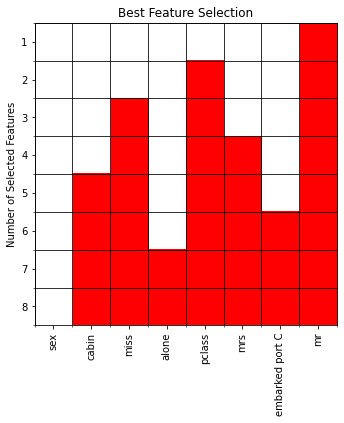

In [13]:
plot_feature_selection(features, selected_features);